<a href="https://colab.research.google.com/github/NosenkoArtem/Categorical-Encoding/blob/master/hw11_unsolved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KV Cache - 10 баллов

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from dataclasses import dataclass

Представим, что у нас есть очень простая мини-LLM:
1. Она эмбеддит токены
2. Считает аттеншн (обычный, не multihead) токенов друг с другом с causal mask (не смотрит в будущее!)
3. После этого выходы attention подаются в линейный слой для получения распределеняи по словарю

На примере такой модели давайте попробуем имплементировать KV-Cache.

Ниже за вас написан метод forward - этот метод это обычный forward нейросети, который считает attention всех токенов со всеми токенами.

Вам же нужно имплементировать метод forward_kv_cache, который принимает:
* x - тензор размерности \[batch, seq_len = 1\]
* prev_output - выход модели с предыдущего шага типа Output

Метод forward_kv_cache должен выполнять следующие действия:
1. Эмбеддинг токена x
2. Проекция x в QKV
3. Расширение k_cache и v_cache из prev_ouptut k/v проекциями x
4. Подсчет аттеншена между q_x и k_cache и v_cache
5. Конкатенация аттеншена в prev_output.attention_weights
6. Возврат logits

In [ ]:
@dataclass
class Output:
    logits: torch.Tensor = None
    k_cache: torch.Tensor = None
    v_cache: torch.Tensor = None
    attn_weights: torch.Tensor = None



class SimpleAttentionLLM(nn.Module):

    def __init__(self, d_model, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.W_Q = nn.Linear(d_model, d_model)
        self.W_K = nn.Linear(d_model, d_model)
        self.W_V = nn.Linear(d_model, d_model)
        self.lin = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        x = self.embedding(x) # batch x seq_len x d_model
        q = self.W_Q(x)       # batch x seq_len x d_model
        k = self.W_K(x)       # batch x seq_len x d_model
        v = self.W_V(x)       # batch x seq_len x d_model

        attn_scores = torch.matmul(q, k.permute(0, 2, 1))               # batch x seq_len x seq_len
        mask = torch.tril(torch.ones_like(attn_scores))                 # batch x seq_len x seq_len
        attn_scores = attn_scores.masked_fill(~mask.bool(), -torch.inf) # batch x seq_len x seq_len
        attn_weights = torch.softmax(attn_scores, dim=2)                # batch x seq_len x seq_len
        weights_V = torch.matmul(attn_weights, v)                       # batch x seq_len x d_model
        logits = self.lin(weights_V)                                    # batch x seq_len x vocab_size
        return Output(
            logits=logits,
            k_cache=k,
            v_cache=v,
            attn_weights=attn_weights # batch, seq_len, seq_len
        )


    def forward_kv_cache(self, x, prev_output):
        x = self.embedding(x)

        # 1. Проецируем x в q, k, v
        q = self.W_Q(x)
        k = self.W_K(x)
        v = self.W_V(x)


        # берем старый кэш
        k_cache = prev_output.k_cache
        v_cache = prev_output.v_cache

        # расширяем его состояниями k, v последнего токена
        # с помощью torch.cat
        k_cache_new = torch.cat([k_cache, k], dim=1)
        v_cache_new = torch.cat([v_cache, v], dim=1)

        # считаем attention_score, то есть матричное умножение между q и k_cache_new
        attn_scores = torch.matmul(q, k_cache_new.permute(0, 2, 1))


        # считаем softmax
        attn_weights = torch.softmax(attn_scores, dim=2)
        # домножаем softmax на V

        weights_V = torch.matmul(attn_weights, v_cache_new)
        logits = self.lin(weights_V)

        batch = x.size(0)
        seq_len = k_cache.size(1)

        attn_weights_old = prev_output.attn_weights
        zeros_right = torch.zeros(batch, seq_len, 1)
        # добавляем нули в аттеншене так, чтобы у старых токенов был нулевой аттеншн на новый токен
        attn_weights_all = torch.cat((attn_weights_old, zeros_right), dim=2)
        # Добавляем аттеншн текущего нового токена по старым
        attn_weights_all = torch.cat((attn_weights_all, attn_weights), dim=1)

        return Output(
            logits=logits,
            k_cache=k_cache_new,
            v_cache=v_cache_new,
            attn_weights=attn_weights_all
        )

torch.manual_seed(1)

batch_size = 1
seq_len = 3
d_model = 128
vocab_size = 7

layer = SimpleAttentionLLM(d_model, vocab_size)
for param in layer.parameters():
    nn.init.normal_(param)

x = torch.randint(0, 7, (batch_size, seq_len))
x_copy = x.clone()

print("Before generation", x)

with torch.no_grad():
    for i in range(10):
        outputs = layer(x)
        logits = outputs.logits
        # берем последний токен, т.к. по нему предсказываем!
        next_token = logits[:, -1].argmax(dim=1, keepdim=True)
        x = torch.cat((x, next_token), dim=1) # добавляем новый токен по размерности seq_len

no_cache_output = outputs
print("After generation no cache", x)


x = x_copy.clone()
final_tokens = x.clone()

with torch.no_grad():
    # prefill
    outputs = layer(x)
    logits = outputs.logits
    # берем последний токен, т.к. по нему предсказываем!
    next_token = logits[:, -1].argmax(dim=1, keepdim=True)
    # обратите внимание, что раньше было 10 шагов!
    final_tokens = torch.cat((final_tokens, next_token), dim=1)
    for i in range(9):
        outputs = layer.forward_kv_cache(next_token, outputs)
        next_token = outputs.logits[:, -1].argmax(dim=1, keepdim=True)
        final_tokens = torch.cat((final_tokens, next_token), dim=1)

print("After generation kv cache", final_tokens)

cache_outputs = outputs


Before generation tensor([[1, 3, 0]])
After generation no cache tensor([[1, 3, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0]])
After generation kv cache tensor([[1, 3, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0]])


Выведем матрицы attention

Text(0.5, 1.0, 'Attention kv cache')

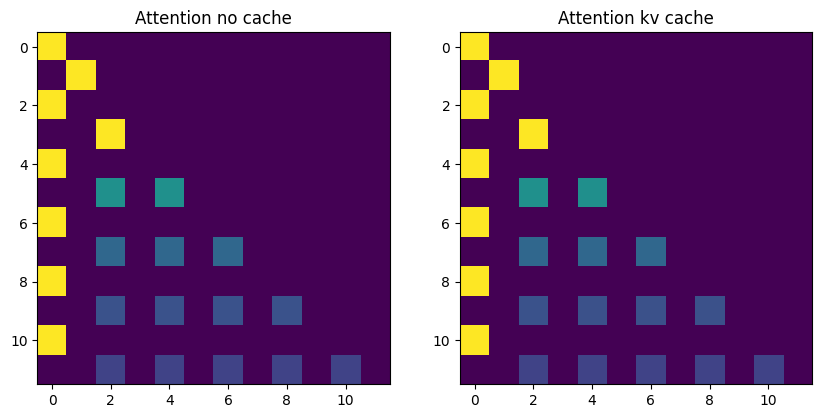

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(no_cache_output.attn_weights[0])
axes[0].set_title("Attention no cache")
axes[1].imshow(cache_outputs.attn_weights[0])
axes[1].set_title("Attention kv cache")

In [ ]:
# 1. Полная очистка окружения
!pip uninstall -y torch vllm transformers
!rm -rf /usr/local/lib/python3.11/dist-packages/torch*

# 2. Установка совместимых версий
!pip install torch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2 --index-url https://download.pytorch.org/whl/cu118
!pip install vllm==0.3.3  # Версия, совместимая с PyTorch 2.1
!pip install hf_xet

Found existing installation: torch 2.1.2+cu118
Uninstalling torch-2.1.2+cu118:
  Successfully uninstalled torch-2.1.2+cu118
Found existing installation: vllm 0.3.3
Uninstalling vllm-0.3.3:
  Successfully uninstalled vllm-0.3.3
Found existing installation: transformers 4.52.3
Uninstalling transformers-4.52.3:
  Successfully uninstalled transformers-4.52.3
Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.1.2%2Bcu118-cp311-cp311-linux_x86_64.whl (2325.9 MB)
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.16.2%2Bcu118-cp311-cp311-linux_x86_64.whl (6.1 MB)
  Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.1.2%2Bcu118-cp311-cp311-linux_x86_64.whl (3.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
outlines 0.0.34 requires transformers, which is not instal

In [ ]:
# !pip install -U ftfy regex timm
# !pip install git+https://github.com/openai/CLIP.git

In [ ]:
# !pip install numpy==1.26.0
# !pip install -q vllm==0.3.3.post1
# !torchvision==0.17.1
# !pip install transformers==4.41.0
!export CUDA_HOME=/usr/local/cuda  # Важно для совместимости

In [ ]:
from transformers import CLIPVisionModel
print("CLIP доступен:", CLIPVisionModel is not None)

CLIP доступен: True


In [ ]:
import subprocess
import time

# Команда запуска (подставьте свою модель)
server_cmd = [
    "python", "-m", "vllm.entrypoints.openai.api_server",
    "--model", "unsloth/gemma-2b-it",         # Лёгкая модель для Colab
    "--tensor-parallel-size", "1",           # 1 GPU
    "--max-num-batched-tokens", "2048",      # Лимит токенов
    "--max-model-len", "2048",               # Макс. длина контекста
    "--dtype", "float16",                    # Для экономии памяти
    "--port", "8000"
]

# Запуск в фоне с перенаправлением логов
with open("vllm.log", "w") as log_file:
    server_process = subprocess.Popen(
        server_cmd,
        stdout=log_file,
        stderr=subprocess.STDOUT
    )

# Дадим серверу 60 секунд на запуск
time.sleep(60)

In [ ]:
import requests

# Проверка здоровья сервера
health_url = "http://localhost:8000/health"
try:
    response = requests.get(health_url)
    print(f"Server status: {response.status_code}")
    print(response.json())
except Exception as e:
    print("Ошибка подключения:", e)
    !cat vllm.log  # Показать логи при ошибке

Server status: 200
Ошибка подключения: Expecting value: line 1 column 1 (char 0)
INFO 05-28 20:50:46 api_server.py:228] args: Namespace(host=None, port=8000, allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key=None, served_model_name=None, lora_modules=None, chat_template=None, response_role='assistant', ssl_keyfile=None, ssl_certfile=None, root_path=None, middleware=[], model='unsloth/gemma-2b-it', tokenizer=None, revision=None, code_revision=None, tokenizer_revision=None, tokenizer_mode='auto', trust_remote_code=False, download_dir=None, load_format='auto', dtype='float16', kv_cache_dtype='auto', max_model_len=2048, worker_use_ray=False, pipeline_parallel_size=1, tensor_parallel_size=1, max_parallel_loading_workers=None, block_size=16, seed=0, swap_space=4, gpu_memory_utilization=0.9, max_num_batched_tokens=2048, max_num_seqs=256, max_paddings=256, disable_log_stats=False, quantization=None, enforce_eager=False, max_context_len_to_cap

In [ ]:
r = requests.post("http://localhost:8000/v1/completions", json={
                  "model": "unsloth/gemma-2b-it",
                  "prompt": "Hello there",
                  "max_tokens": 20,
                  "temperature": 0.8
              })
print(r.json())
print(r.json()["choices"][0]["text"])

{'id': 'cmpl-dd21fae22c8c475aa0b9eb8f2676d89f', 'object': 'text_completion', 'created': 2704, 'model': 'unsloth/gemma-2b-it', 'choices': [{'index': 0, 'text': ', I am interested in learning more about your work and how I can get in touch with you.', 'logprobs': None, 'finish_reason': 'length'}], 'usage': {'prompt_tokens': 3, 'total_tokens': 23, 'completion_tokens': 20}}
, I am interested in learning more about your work and how I can get in touch with you.


In [ ]:
!pip install -q vllm triton

In [ ]:
# # Запуск сервера в фоне
# import subprocess
# vllm_process = subprocess.Popen([
#     "python", "-m", "vllm.entrypoints.openai.api_server",
#     "--model", "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
#     "--trust-remote-code",
#     "--dtype", "half",
#     "--max-model-len", "8192"
# ], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

In [ ]:
# import requests
# response = requests.get("http://localhost:8000/health")
# print("Status:", response.status_code)

По возможности данное задание необходимо выполнять на сервере, чтобы было удобно запускать параллельно фреймворк и нагрузочное тестирование. Для удобства работы в jupyter сделан следующий трюк

In [ ]:
# import time
# import multiprocessing
# import subprocess

# def start_vllm_server():
#     # This function will run the `vllm` server command
#     cmd = ["vllm", "serve", "unsloth/gemma-2b-it", "--dtype", "half"]
#     subprocess.run(cmd)


# server_process = multiprocessing.Process(target=start_vllm_server)
# server_process.start()
# time.sleep(60)
# print("we are probably ready")

# import requests

# r = requests.post("http://localhost:8000/v1/completions", json={
#                   "model": "unsloth/gemma-2b-it",
#                   "prompt": "Hello there",
#                   "max_tokens": 20,
#                   "temperature": 0.8
#               })
# print(r.json())
# print(r.json()["choices"][0]["text"])

# Нагрузочное тестирование - 25 баллов

20 баллов - узнать, сколько запросов в секунду выдержит VLLM сервинг модели при ограничении latency в 5 секунд.
Можно использовать самописную функцию через multiprocessing/threading, можно использовать любой готовый инструмент.

В качестве пейлоадов предлагается брать тексты длины 100-128 и генерировать к ним не более 10 токенов. Сами пейлоады можно взять из любого датасета, например https://huggingface.co/datasets/Intel/orca_dpo_pairs.

Об аргументах vllm serve можно почитать в документации https://docs.vllm.ai/en/latest/serving/openai_compatible_server.html


5 баллов - если сможете посчитать на этом пейлоаде ttft - time to first token, то есть сколько занимает prefill стадия генерации.

# Часть 2
Далее предоставлено 2 варианта выполнения задания. Баллы будут начисляться только на один из них
## Вариант 1. Квантизация - 15 баллов
Квантизируйте модель в VLLM любым доступным способом, напишите, как сократились затраты памяти и как изменилась скорость инференса. Обязательно укажите, на какой видеокарте проводились замеры!
Не забудьте про то, что квантизировать можно и kv cache.

Внимательно проверьте и убедитесь, что ваш ускоритель поддержан в https://docs.vllm.ai/en/latest/quantization/supported_hardware.html

## Вариант 2. Батчевалка - 15 баллов
Предлагается написать сервер на питоне, который поддерживал бы батчевание запросов.

Сервер принимает POST запрос с телом вида

```json
{"text": "Hello there"}
```


Необходимо написать сервер, который:
1. Имел бы возможность работать с несколькими клиентами за раз (не блокировался бы на обработку одного запроса). Для этого можно использовать async, gevent, треды и т.д.
2. Использовал бы батчовую обработку следующим образом:
если пришло несколько запросов (для примера 2)

```json
запрос 1
{"text": "Hello there "}
запрос 2
{"text": "handsome"}
```

то каждый клиент получал бы в ответ конкатенацию этих запросов (в произвольном порядке), т.е. оба клиента получили бы ответ
```json
{"text": "Hello there handsome"}
или
{"text": "handsomeHello there "}
```

Сервер должен иметь 2 конфигурируемых параметра:
1. Максимальный размер батча, который он может обработать
2. Максимальное время ожидания, которое ждет сэмпл перед обработкой. Т.е. если у нас батч размера 5, а у нас всего один сэмпл, и прошло максимальное время ожидания - этот сэмпл попадает в батч один и обрабатывается один.

Для хранения данных в очереди можно использовать queue.Queue или любой другой удобный способ.